In [282]:
def transform(x):
  if(x['year'] <= 1993): #rounds before 1993 did not have 32 rounds per pick. We should standardize to today's standard
    x['rnd'] = 1 + int(x['pick'] / 32)
  return x

data = data.apply(func=transform, axis=1, result_type='broadcast')



In [284]:
rounds_as_ints = data['rnd']
data.loc[rounds_as_ints <= 3, 'rnd'] = '1-3'
data.loc[rounds_as_ints > 3 and data['rnd'] <= 6 , 'rnd'] = '4-6'
data.loc[rounds_as_ints > 6, 'rnd'] = '>7'
data

TypeError: '<=' not supported between instances of 'str' and 'int'

In [ ]:
labels = data['rnd']

#pick directly correlates with round. keeping it as a feature would be data leakage
features = data.drop(['pick'], axis=1)
print(features.head())

In [ ]:
null_cmps.loc[null_cmps['pos'] == 'QB']

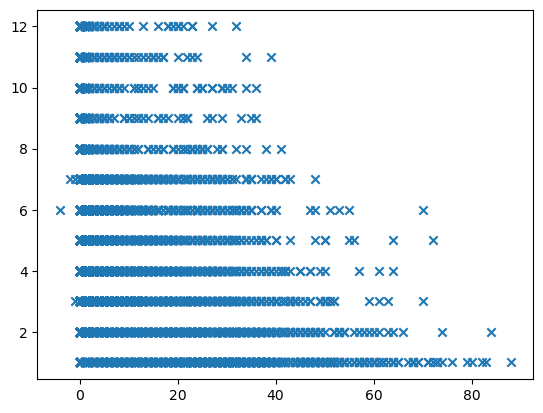

In [ ]:
features[['first4av', 'rnd']]
plt.scatter(x=features['first4av'], y=features['rnd'], marker='x')

In [ ]:
# use counter to get frequency of each label
frequency = collections.Counter(labels)

# printing the frequency to view any class imbalances between the rounds
print(dict(frequency))

{1: 970, 2: 985, 3: 1041, 4: 1075, 5: 1063, 6: 1127, 7: 1284, 8: 257, 9: 256, 10: 256, 11: 121}


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
# params = {"max_depth": [5,10,15,20], "min_samples_leaf": [5,10,15,20]}
# grid_search = GridSearchCV(clf, params, cv=5, scoring='accuracy') #inner loop
# replace clf with grid_search if you want to test parameters
nested_score = cross_val_score(clf, features, labels, cv=5) #outer loop
print("Accuracy:", nested_score.mean()*100)

c:\Users\lawso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 165, in fit
    X, y = self._validate_data(
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\base.py",

Accuracy: nan


c:\Users\lawso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
240 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 165, in fit
    X, y = self._validate_data(
  File "c:\Users\lawso\anaconda3\lib\site-packages\sklearn\base.py",

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
scores = cross_val_score(clf, features, labels, cv=10)                                       
print("Accuracy:", scores.mean()*100)

#Alternative (cross_val_predict instead of cross_val_score) to analyze the results in more detail:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
clf = GaussianNB()
predicts = cross_val_predict(clf, features, labels, cv=10) 
print("Predictions:", predicts) 
print("Confusion Matrix:\n", confusion_matrix(labels, predicts))
print("Report:\n", classification_report(labels, predicts))